# Part 1, Topic 2: Clock Glitching to Dump Memory (MAIN)

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *Similarly to clock glitching, inserting brief glitches into the power line of an embedded device can result in skipped instructions and corrupted results. Besides providing a more reliable glitch on some targets when compared to clock glitching, voltage glitching also has the advanatage that the Vcc pins on chips are always accessable. This won't be covered in this course, but it can also be used to glitch a device asynchronous to its clock.*

**LEARNING OUTCOMES:**

* Understanding voltage glitch settings
* Building a voltage glitch and crash map.

## Voltage Glitch Hardware

The ChipWhisperer uses the same hardware block for both voltage and clock glitching, with the only difference being where the glitch output is routed to. Instead of routing to HS2, voltage glitching is performed by routing the glitch to either the `glitch_hp` transistor or the `glitch_lp` transistor. This can be done via the following API calls:

```python
scope.io.glitch_hp = True #enable HP glitch
scope.io.glitch_hp = False #disable LP glitch
scope.io.glitch_lp = True #enable LP glitch
scope.io.glitch_lp = False #disable LP glitch
```

While the hardware block are the same, you'll need to change how it's configued. You wouldn't want to try routing `"clock_xor"` to the glitch transistor and oscillate Vcc like the device's clock! Instead, the following two output settings are best suited to voltage glitching:

1. `"glitch_only"` - insert a glitch for a portion of a clock cycle based on `scope.glitch.width` and `scope.glitch.offset`
1. `"enable_only"` - insert a glitch for an entire clock cycle

Typically, the `"enable_only"` setting will be too powerful for most devices. One situation where it outshines `"glitch_only"` is in glitching asychronous to the target's clock. An example of this is glitching a target with an internal clock. In this case, the ChipWhisperer's clock can be boosted far above the target's to insert a precise glitch, with `repeat` functioning as `width` and `ext_offset` functioning as `offset`.

To introduce you to volatge glitching and find some settings, we're going to walk back through the clock glitching loop lab. In addition, voltage glitching behaves much differently than clock glitching. There's a bunch of things on the target side such as the power supply ciruitry and capacitors trying to keep the voltage at a stable level. The shunt resistor will help us drop the voltage, but keep in mind that short glitches around zero width won't do much to the target's supply voltage. You may want to capture some power traces while you're first experimenting with glitches to see what effects different glitch widths have on the power trace. Another thing to keep in mind is that targets often won't tolerate the Vcc pin dropping for an extended period of time without crashing - once you see the target start to crash, you won't see much else with larger widths.

You've already run through this lab once, so you'll be mostly on your own.

In [207]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'

In [208]:
%%bash -s "$PLATFORM"
cd ../../../hardware/victims/firmware/simpleserial-glitch
make PLATFORM=$1 CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
rm -f -- simpleserial-glitch-CWLITEARM.hex
rm -f -- simpleserial-glitch-CWLITEARM.eep
rm -f -- simpleserial-glitch-CWLITEARM.cof
rm -f -- simpleserial-glitch-CWLITEARM.elf
rm -f -- simpleserial-glitch-CWLITEARM.map
rm -f -- simpleserial-glitch-CWLITEARM.sym
rm -f -- simpleserial-glitch-CWLITEARM.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-glitch.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s
rm -f -- simpleserial-glitch.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d
rm -f -- simpleserial-glitch.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc.exe (GNU Tools for ARM Embedded Processors 6-2017-q1-update) 6.3.1 20170215 (release) [ARM/embedded-6-branch revision 245512]
Copyright (C) 2016 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warr

In [209]:
%run "../../Helper_Scripts/Setup_Generic.ipynb"

Serial baud rate = 38400
INFO: Found ChipWhisperer😍


In [228]:
fw_path = "../../../hardware/victims/firmware/simpleserial-glitch/simpleserial-glitch-{}.hex".format(PLATFORM)
cw.program_target(scope, prog, fw_path)

Serial baud rate = 115200
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5287 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5287 bytes
Serial baud rate = 38400


In [211]:
def reboot_flush():            
    scope.io.nrst = False
    time.sleep(0.05)
    scope.io.nrst = True
    time.sleep(0.05)
    #Flush garbage too
    target.flush()

## Communication

For this lab, we'll be introducing a new method: `target.simpleserial_read_witherrors()`. We're expecting a simpleserial response back; however, glitch will often cause the target to crash and return an invalid string. This method will handle all that for us. It'll also tell us whether the response was valid and what the error return code was. Use as follows:

In [231]:
#Do glitch loop
target.write("g\n")

val = target.simpleserial_read_witherrors('r', 4)#For loop check
valid = val['valid']
if valid:
    response = val['payload']
    raw_serial = val['full_response']
    error_code = val['rv']

print(val)

{'valid': True, 'payload': CWbytearray(b'c4 09 00 00'), 'full_response': 'rC4090000\n', 'rv': 0}


## Target Firmware

For this lab, our goal is to get the following code to preduce an incorrect result:

```C
uint8_t glitch_loop(uint8_t* in)
{
    volatile uint16_t i, j;
    volatile uint32_t cnt;
    cnt = 0;
    trigger_high();
    for(i=0; i<50; i++){
        for(j=0; j<50; j++){
            cnt++;
        }
    }
    trigger_low();
    simpleserial_put('r', 4, (uint8_t*)&cnt);
    return (cnt != 2500);
}
```

As you can see, we've got a simple loop. This is a really good place to start glitching for 2 reasons:

1. We've got a really long portion of time with a lot of instructions to glitch. In contrast, with the Linux example we're be trying to target a single instruction.

1. For some glitching scenarios, we're looking for a pretty specific glitch effect. In the Linux example, we might be banking on the glitch causing the target to skip an instruction instead of corrupting the comparison since that's a lot more likely to get us where we want in the code path. For this simple loop calculation, pretty much any malfunction will show up in the result.

## Glitch Module

All the settings/methods for the glitch module can be accessed under `scope.glitch`. As usual, documentation for the settings and methods can be accessed on [ReadtheDocs](https://chipwhisperer.readthedocs.io/en/latest/api.html) or with the python `help` command:

In [213]:
help(scope.glitch)

Help on GlitchSettings in module chipwhisperer.capture.scopes.cwhardware.ChipWhispererGlitch object:

class GlitchSettings(chipwhisperer.common.utils.util.DisableNewAttr)
 |  GlitchSettings(cwglitch)
 |  
 |  Provides an ability to disable setting new attributes in a class, useful to prevent typos.
 |  
 |  Usage:
 |  1. Make a class that inherits this class:
 |  >>> class MyClass(DisableNewAttr):
 |  >>>     # Your class definition here
 |  
 |  2. After setting up all attributes that your object needs, call disable_newattr():
 |  >>>     def __init__(self):
 |  >>>         self.my_attr = 123
 |  >>>         self.disable_newattr()
 |  
 |  3. Subclasses raise an AttributeError when trying to make a new attribute:
 |  >>> obj = MyClass()
 |  >>> #obj.my_new_attr = 456   <-- Raises AttributeError
 |  
 |  Method resolution order:
 |      GlitchSettings
 |      chipwhisperer.common.utils.util.DisableNewAttr
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, cw

Some of the important settings we'll want to look at here are:

* clk_src
> The clock signal that the glitch DCM is using as input. Can be set to "target" or "clkgen" In this case, we'll be providing the clock to the target, so we'll want this set to "clkgen"
* offset
> Where in the output clock to place the glitch. Can be in the range `[-50, 50]`. Often, we'll want to try many offsets when trying to glitch a target.
* width
> How wide to make the glitch. Can be in the range `[-50, 50]`. Wider glitches more easily cause glitches, but are also more likely to crash the target, meaning we'll often want to try a range of widths when attacking a target.
* output
> The output produced by the glitch module. For clock glitching, clock_xor is often the most useful option.
* ext_offset
> The number of clock cycles after the trigger to put the glitch. 
* repeat
> The number of clock cycles to repeat the glitch for. Higher values increase the number of instructions that can be glitched, but often increase the risk of crashing the target.
* trigger_src
> How to trigger the glitch. For this tutorial, we want to automatically trigger the glitch from the trigger pin only after arming the ChipWhipserer, so we'll use `ext_single`

In addition, we'll need to tell ChipWhipserer to use the glitch module's output as a clock source for the target by setting `scope.io.hs2 = "glitch"`. We'll also setup a large `repeat` to make glitching easier. Finally, we'll also use a `namedtuple` to make looping through parameters simpler.

## CW Glitch Controller

To make creating a glitch loop easier, ChipWhisperer includes a glitch controller. We'll start of by initializing with with different potential results of the attack. You define these to be whatever you want, but typically "success", "reset", and "normal" will be sufficient. We also need to tell it what glitch parameters we want to scan through, in this case width and offset:

In [214]:
# GlitchController will be part of ChipWhisperer core - just run this block
# for now.

%matplotlib notebook


import ipywidgets as widgets          
import chipwhisperer.common.results.glitch as glitch

class GlitchController:
    
    def __init__(self, groups, parameters):
        self.groups = groups
        self.parameters = parameters
        
        self.results = glitch.GlitchResults(groups=groups, parameters=parameters)
        
        self.parameter_min = [0.0] * len(parameters)
        self.parameter_max = [10.0] * len(parameters)
        self.steps = [1]
        
        self.widget_list_parameter = None
        self.widget_list_groups = None
        
        self.clear()
        
    def clear(self):
        self.results.clear()        
        self.group_counts = [0] * len(self.groups)
        
        if self.widget_list_groups:
            for w in self.widget_list_groups:
                w.value = 0
        
    def set_range(self, parameter, low, high):
        
        if high < low:
            t = low
            low = high
            high = t
        
        i = self.parameters.index(parameter)
        self.parameter_min[i] = low
        self.parameter_max[i] = high
        
        if self.widget_list_parameter:
            # When changing them, need to ensure we don't have min > max ever or will throw
            # an error, so we set max to super-high first.
            self.widget_list_parameter[i].max = 1E9
            self.widget_list_parameter[i].min = low
            self.widget_list_parameter[i].max = high
    
    def set_step(self, parameter, step):
        '''Set size, can be either a single value or a list of step-sizes to iterate through'''
        raise NotImplementedError("TODO")
        
    def set_global_step(self, steps):
        '''Set step for all parameters (Eventually support per-parameter)'''
        if hasattr(steps, "__iter__"):
            self.steps = steps
        else:
            self.steps = [steps]
    
    def add(self, group, parameters, strdesc=None, metadata=None):
        self.results.add(group, parameters, strdesc, metadata)    
        
        i = self.groups.index(group)        
        #Basic count
        self.group_counts[i] += 1
        self.widget_list_groups[i].value =  self.group_counts[i]
    
    def display_stats(self):
        
        self.widget_list_groups = [widgets.IntText(value=0, description=group + " count:", disabled=True)
                                   for group in self.groups]
        
        self.widget_list_parameter = [widgets.FloatSlider(
                                            value=self.parameter_min[i],
                                            min=self.parameter_min[i],
                                            max=self.parameter_max[i],
                                            step=0.01,
                                            description=p + " setting:",
                                            disabled=True,
                                            continuous_update=False,
                                            orientation='horizontal',
                                            readout=True,
                                            readout_format='.01f')
                                          for i,p in enumerate(self.parameters)]
            
        display(*(self.widget_list_groups + self.widget_list_parameter))
       
        
    def glitch_values(self, clear=True):
        """Generator returning the given parameter values in order, using the step size (or step list)"""
        
        self.parameter_values = self.parameter_min[:]
        
        if clear:
            self.clear()
        
        for stepsize in self.steps:
            for val in self._loop_rec(0, len(self.parameter_values)-1, stepsize):
                if self.widget_list_parameter:
                    for i,v in enumerate(val):
                        self.widget_list_parameter[i].value = v
                yield val
        
    def _loop_rec(self, parameter_index, final_index, step):
        self.parameter_values[parameter_index] = self.parameter_min[parameter_index]
        if parameter_index == final_index:            
            while self.parameter_values[parameter_index] <= self.parameter_max[parameter_index]:                                
                yield self.parameter_values
                self.parameter_values[parameter_index] += step
        else:
            while self.parameter_values[parameter_index] <= self.parameter_max[parameter_index]: 
                yield from self._loop_rec(parameter_index+1, final_index, step)
                self.parameter_values[parameter_index] += step

In [215]:
gc = GlitchController(groups=["success", "reset", "normal"], parameters=["width", "offset", "ext_offset"])

One of the nicities of the glitch controller is that it can display our current settings. This will update in real time as we use the glitch controller!

We can also make a settings map that can also update in realtime as well:

<IPython.core.display.Javascript object>


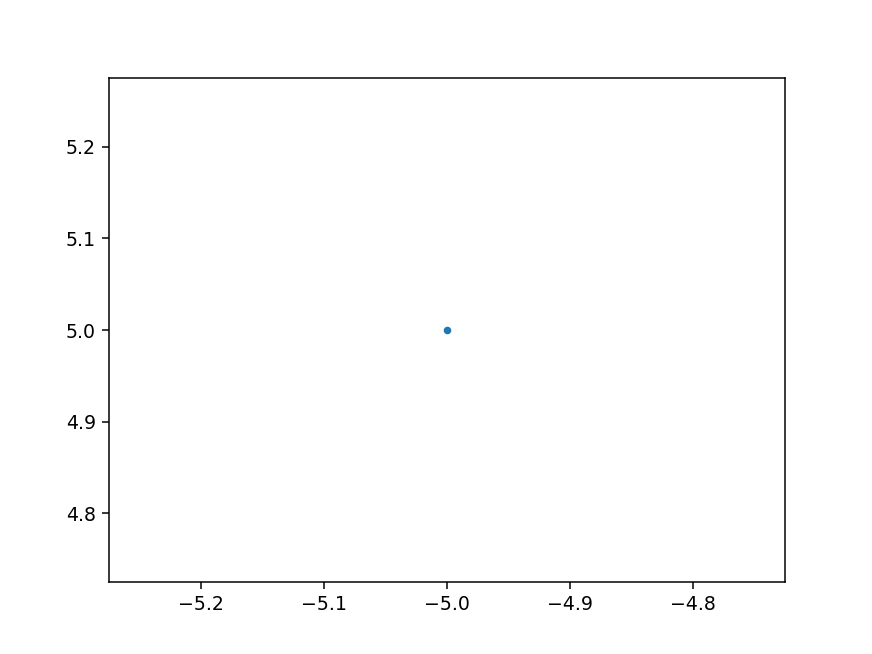

In [216]:
## to update the plot:
%matplotlib notebook
import matplotlib.pylab as plt
fig = plt.figure()
plt.plot(-5, 5, '.')
fig.canvas.draw()

You can set ranges for each glitch setting:

In [220]:
gc.set_range("width", -5, 5)
gc.set_range("offset", -5, 5)

Each setting moves from min to max based on the global step:

In [221]:
gc.set_global_step([5.0, 2.5])

We can print out all the glitch settings to see how this looks:

In [222]:
for glitch_setting in gc.glitch_values():
    print("Offset: {}", glitch_setting[1])
    print("Width: {}", glitch_setting[0])

Offset: {} -5
Width: {} -5
Offset: {} -5
Width: {} -5
Offset: {} -5
Width: {} -5
Offset: {} 0.0
Width: {} -5
Offset: {} 0.0
Width: {} -5
Offset: {} 0.0
Width: {} -5
Offset: {} 5.0
Width: {} -5
Offset: {} 5.0
Width: {} -5
Offset: {} 5.0
Width: {} -5
Offset: {} -5
Width: {} 0.0
Offset: {} -5
Width: {} 0.0
Offset: {} -5
Width: {} 0.0
Offset: {} 0.0
Width: {} 0.0
Offset: {} 0.0
Width: {} 0.0
Offset: {} 0.0
Width: {} 0.0
Offset: {} 5.0
Width: {} 0.0
Offset: {} 5.0
Width: {} 0.0
Offset: {} 5.0
Width: {} 0.0
Offset: {} -5
Width: {} 5.0
Offset: {} -5
Width: {} 5.0
Offset: {} -5
Width: {} 5.0
Offset: {} 0.0
Width: {} 5.0
Offset: {} 0.0
Width: {} 5.0
Offset: {} 0.0
Width: {} 5.0
Offset: {} 5.0
Width: {} 5.0
Offset: {} 5.0
Width: {} 5.0
Offset: {} 5.0
Width: {} 5.0
Offset: {} -5
Width: {} -5
Offset: {} -5
Width: {} -5
Offset: {} -5
Width: {} -5
Offset: {} -5
Width: {} -5
Offset: {} -5
Width: {} -5
Offset: {} -2.5
Width: {} -5
Offset: {} -2.5
Width: {} -5
Offset: {} -2.5
Width: {} -5
Offset: {} -2

You can tell the glitch controller when you've reached a particular result state like so:

In [223]:
#gc.add("reset", (scope.glitch.width, scope.glitch.offset))
#gc.add("success", (scope.glitch.width, scope.glitch.offset))

We'll start off with the following settings. It's usually best to use "clock_xor" with clock glitching, which will insert a glitch if the clock is high or the clock is low.

In [232]:
#Basic setup
scope.glitch.clk_src = "clkgen" # set glitch input clock
scope.glitch.output = "glitch_only" # glitch_out = clk ^ glitch
scope.glitch.trigger_src = "ext_single" # glitch only after scope.arm() called

scope.io.glitch_hp = True
scope.io.glitch_lp = False
print(scope.glitch)

clk_src     = clkgen
width       = -28.90625
width_fine  = 0
offset      = -47.65625
offset_fine = 0
trigger_src = ext_single
arm_timing  = after_scope
ext_offset  = 2
repeat      = 2
output      = glitch_only



Unless you don't mind your computer being occupied for a few days, you'll want to break this into two glitch campaigns. The first will be with wide ranges and large steps. Then, once you've found some interesting locations, narrow down your ranges and step size to more precisely map out what the best settings are.

We'll get you started, but it's up to you to finish the loop.

<IPython.core.display.Javascript object>


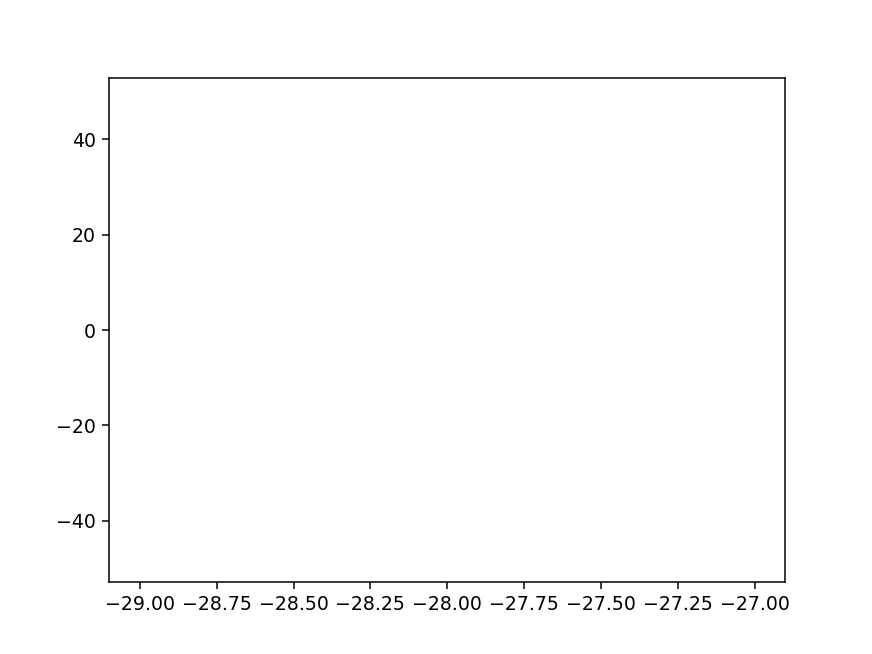

In [225]:
%matplotlib notebook
import matplotlib.pylab as plt
fig = plt.figure()



In [226]:
gc.display_stats()

IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=-5.0, continuous_update=False, description='width setting:', disabled=True, max=5.0, min=-5.…

FloatSlider(value=-5.0, continuous_update=False, description='offset setting:', disabled=True, max=5.0, min=-5…

FloatSlider(value=0.0, continuous_update=False, description='ext_offset setting:', disabled=True, max=10.0, re…

In [237]:
from importlib import reload
import chipwhisperer.common.results.glitch as glitch
from tqdm import tnrange
import struct
scope.glitch.ext_offset = 13

scope.glitch.width_fine = 0
scope.glitch.offset_fine = 0
#gc.set_range("width", 29.2, 29.7)
#gc.set_range("width", 27, 29.8)
gc.set_range("width", -28, -27)

div = 1
gc.set_range("offset", -48/div, 48/div)
#gc.set_range("offset", -20.3/div, -19.2/div)
gc.set_global_step([0.2])

gc.set_range("ext_offset", 2*.4, 15*.4)

plt.plot(gc.parameter_min[0], gc.parameter_min[1], ' ')
plt.plot(gc.parameter_min[0], gc.parameter_max[1], ' ')
plt.plot(gc.parameter_max[0], gc.parameter_min[1], ' ')
plt.plot(gc.parameter_max[0], gc.parameter_max[1], ' ')

#gc.set_range("width", 28, 30)
#gc.set_range("offset", -22, -20)
#gc.set_global_step([0.4])
scope.glitch.repeat = 2

scope.adc.timeout = 0.1

reboot_flush()
sample_size = 1
loff = scope.glitch.offset
lwid = scope.glitch.width

for glitch_setting in gc.glitch_values():
    scope.glitch.offset = glitch_setting[1] * div
    scope.glitch.width = glitch_setting[0]
    scope.glitch.ext_offset = glitch_setting[2] / 0.4
    #print(scope.glitch.ext_offset)
    for i in range(1):
        target.flush()
        if scope.adc.state:
            # can detect crash here (fast) before timing out (slow)
            print("Trigger still high!")
            gc.add("reset", (scope.glitch.width, scope.glitch.offset))
            #plt.plot(lwid, loff, 'xr', alpha=1)
            #fig.canvas.draw()

            #Device is slow to boot?
            reboot_flush()
            
        scope.arm()
        
        #Do glitch loop
        target.write("g\n")
        
        ret = scope.capture()
        
        
        val = target.simpleserial_read_witherrors('r', 4)#For loop check
        loff = scope.glitch.offset
        lwid = scope.glitch.width
        scope.io.glitch_hp = False
        scope.io.glitch_hp = True
        
        if ret:
            print('Timeout - no trigger')
            gc.add("reset", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
            #plt.plot(scope.glitch.width, scope.glitch.offset, 'xr', alpha=1)
            #fig.canvas.draw()

            #Device is slow to boot?
            reboot_flush()

        else:
            if val['valid'] is False:
                #print("Invalid response: ", val['full_response'])
                gc.add("reset", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
                #plt.plot(scope.glitch.width, scope.glitch.offset, 'xr', alpha=1)
                #fig.canvas.draw()
            else:
                gcnt = struct.unpack("<I", val['payload'])[0]

                #print(gcnt)                
                # for table display purposes
                #if gnt != 0: #for code-flow check
                if gcnt != 2500: #for loop check
                    gc.add("success", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
                    #plt.plot(scope.glitch.width, scope.glitch.offset, '+g')
                    #fig.canvas.draw()
                    print("🐙", end="")
                    print(val['payload'])
                    print(scope.glitch.width, scope.glitch.offset)
                else:
                    gc.add("normal", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
                    #plt.plot(scope.glitch.width, scope.glitch.offset, '.k', alpha=0.1)
                   # fig.canvas.draw()
                    

print("Done glitching")

🐙CWbytearray(b'16 7f ae 7d')
-28.125 -41.015625
🐙CWbytearray(b'93 09 00 00')
-28.125 -40.625


🐙CWbytearray(b'c6 4d 08 24')
-27.734375 -41.40625
🐙CWbytearray(b'1f 82 af 2f')
-27.734375 -41.015625


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


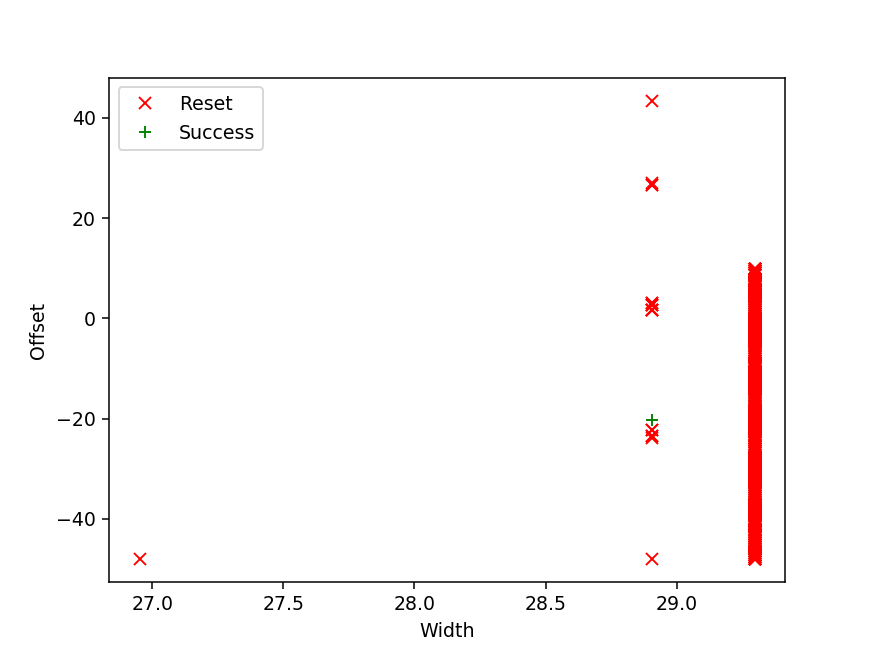

In [206]:
%matplotlib notebook
import matplotlib.pylab as plt

# plot_2d is part of CW core, but has some bugs with huge data (like generated here) where you don't
# want to plot everything. For now just use the following which replaces the plot_2d function with some bug-fixes

def plot_2d(self, plotdots, x_index=0, y_index=1, x_units=None, y_units=None, mask=True):
    '''
    Generate a 2D plot of glitch success rate using matplotlib.

    Plotting is done in the default figure - you may need to call plt.figure() before and
    plt.show() after calling this function if you want more control (or the figure does
    not show by default).
    '''

    data = self.calc()

    #We only want legend to show for first element... bit of a hack here
    legs = self.groups[:]

    #Generate success rates
    for p in data:
        #Plot based on non-zero priority if possible
        for g in self.groups:
            if plotdots[g]:
                if p[g] > 0:
                    if g in legs:
                        leg = g.title()
                        #No need to show this one anymore
                        legs.remove(g)
                    else:
                        leg = None

                    sr = float(p[g]) / float(p['_total']) + 0.5
                    
                    if sr > 1.0:
                        sr = 1.0
                    
                    plt.plot(p['_parameter'][x_index], p['_parameter'][y_index], plotdots[g], alpha=sr, label=leg)

                    if mask:
                        break

    xlabel = self.parameters[x_index].title()
    if x_units:
        xlabel += " (" + x_units + ")"
    plt.xlabel(xlabel)

    ylabel = self.parameters[y_index].title()
    if y_units:
        ylabel += " (" + y_units + ")"
    plt.ylabel(ylabel)

    plt.legend()

# Plot the results. If you have no glitches or resets this will generat an error -
# this is expected behaviour as we also tell it not to plot the "normal" responses.
plot_2d(gc.results, plotdots={"success":"+g", "reset":"xr", "normal":None})

Make sure you write down those glitch settings, since we'll be using for the rest of the glitching labs! In fact, we'll be using a lot of the general code structure here for the rest of the labs, with the only big changes being:

### Repeat

This lab used a pretty large repeat value. Like the name suggests, this setting controls how many times the glitch is repeated (i.e. a repeat value of 5 will place glitches in 5 consecutive clock cycles). Consider that each glitch inserted has a chance to both cause a glitch or crash the device. This was pretty advantageous for this lab since we had a lot of different spots we wanted to place a glitch - using a high repeat value increased our chance for a crash, but also increased our chance for a successful glitch. For an attack where we're targeting a single instruction, we don't really increase our glitch chance at all, but still have the increased crash risk. Worse yet, a successful glitch in a wrong spot may also cause a crash! It is for that reason that it's often better to use a low repeat value when targeting a single instruction.

### Ext Offset

The ext offset setting controls a delay between the trigger firing and the glitch being inserted. Like repeat, it's base on whole clock cycles, meaning an ext offset of 10 will insert a glitch 10 cycles after the trigger fires. We didn't have to worry about this setting for this lab since the large repeat value was able to take us into the area we wanted. This won't be true for many applications, where you'll have to try glitches at a large variety of ext_offsets.

### Success, Reset, and Normal

These three result states are usually enough to describe most glitch results. What constitues a success, however, will change based on what firmware you're attacking. For example, if we were attacking the Linux authentication, we might base success on a check to see whether or not we're root.